### In this notebook, we will change the max_depth parameter and observe how two parameters change:
### 1) the number of leaf nodes
### 2) the distribution of samples in the leaf nodes

In [1]:
# Import libraries and settings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 12)
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Import data and rename column
cc_data = pd.read_excel('cc_data_uci.xls')
cc_data.rename(columns={'default payment next month': 'OUTPUT'}, inplace = True)
# Separate inputs: X and output:y
X = cc_data.drop(['OUTPUT'], axis = 1)
y = cc_data['OUTPUT']

# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/3, random_state=23)

### - Create simple Decision Tree Classifiers for different hyper-parameter values of max_depth: (1, 6) <br> - Fit the 6 classifiers <br> - Estimate the leaves and their distribution

In [2]:
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(1, 7)
estimator_max_depth = []
leafs = []
unique = []
frequencies = []

In [3]:
for i in max_depth_range:
    estimator_max_depth.append(DecisionTreeClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train, y_train)
    leafs.append(estimator_max_depth[i-1].apply(X_train)) # .apply gives you the leaf number that each sample falls in
    unique.append(np.unique(leafs[i-1], return_counts=True))
    frequencies.append(np.asarray(unique))

In [4]:
leaves_distribution = pd.DataFrame(frequencies[-1], columns=['LEAF_ID', 'SAMPLES_PER_LEAF'])
leaves_distribution.insert(0, 'MAX_DEPTH', 1 + leaves_distribution.index)
leaves_distribution

,MAX_DEPTH,LEAF_ID,SAMPLES_PER_LEAF
0,1,"[1, 2]","[8937, 1063]"
1,2,"[2, 3, 5, 6]","[8173, 764, 32, 1031]"
2,3,"[3, 4, 6, 7, 10, 11, 13, 14]","[2480, 5693, 706, 58, 22, 10, 589, 442]"
3,4,"[4, 5, 7, 8, 11, 12, 14, 15, 19, 20, 21, 24, 2...","[2115, 365, 5420, 273, 494, 212, 56, 2, 19, 3,..."
4,5,"[5, 6, 8, 9, 12, 13, 15, 16, 20, 21, 23, 24, 2...","[1011, 1104, 64, 301, 1341, 4079, 72, 201, 53,..."
5,6,"[6, 7, 9, 10, 13, 14, 16, 17, 21, 22, 24, 25, ...","[823, 188, 1100, 4, 46, 18, 216, 85, 1279, 62,..."


### The dataframe above contains: <br> - LEAF_ID: a list of numpy arrays with the LEAF_ID; e.g. 2 leaves for max_depth=1, 4 leaves for max_depth=2, 8 leaves for max_depth=3 <br> - SAMPLES_PER_LEAF: a list of numpy arrays with the corresponding samples that fall in each leaf
### 
### To further proceed, we need to "explode" the lists and calculate some statistical metrics of the 6 trees

In [5]:
LEAF_ID = leaves_distribution[['MAX_DEPTH', 'LEAF_ID']].explode('LEAF_ID').reset_index(drop=True)
SAMPLES_PER_LEAF = leaves_distribution[['MAX_DEPTH', 'SAMPLES_PER_LEAF']].explode('SAMPLES_PER_LEAF').reset_index(drop=True)
leaves_distribution_exploded = LEAF_ID.merge(SAMPLES_PER_LEAF, left_index = True, right_index = True)
leaves_distribution_exploded = leaves_distribution_exploded.drop('MAX_DEPTH_y', axis = 1).rename(columns = {'MAX_DEPTH_x': 'MAX_DEPTH'})
leaves_distribution_exploded

,MAX_DEPTH,LEAF_ID,SAMPLES_PER_LEAF
0,1,1,8937
1,1,2,1063
2,2,2,8173
3,2,3,764
4,2,5,32
...,...,...,...
100,6,89,18
101,6,92,27
102,6,93,17
103,6,95,29


### Explore how many leaves each tree builds. <br> Also compare it with the maximum theoretical number of leaves if we assume that every split produces 2 nodes (i.e. 2^DEPTH).
### Notice that for max_depth > 3, the actual count of leaves is smaller that the maximum theoretical leaves count. Why?

In [6]:
leaves_per_tree = leaves_distribution_exploded.groupby('MAX_DEPTH').count()
leaves_per_tree = leaves_per_tree.rename(columns = {'LEAF_ID': 'ACTUAL_LEAVES_COUNT'}).drop('SAMPLES_PER_LEAF', axis = 1)
leaves_per_tree['MAX_THEOR_LEAVES_COUNT'] = 2 ** leaves_per_tree.index
leaves_per_tree

,ACTUAL_LEAVES_COUNT,MAX_THEOR_LEAVES_COUNT
MAX_DEPTH,,
1,2,2
2,4,4
3,8,8
4,15,16
5,27,32
6,49,64


### Generate the distribution of the SAMPLES_PER_LEAF for different MAX_DEPTH values

In [7]:
# Create the bins we want to explore. You may try different values, but here I try bins in the logarithmic scale.
bins = [0, 10, 100, 1000, 10000]
BINS = (len(bins) - 1) * [None]
for i in range(len(bins) - 1):
    BINS[i] = str(bins[i]) + '-' + str(bins[i+1] - 1) + str(' SAMPLES')
    
BINS

['0-9 SAMPLES', '10-99 SAMPLES', '100-999 SAMPLES', '1000-9999 SAMPLES']

In [8]:
leaves_per_tree_distribution = []
for i in max_depth_range:
    leaves_per_tree_distribution.append(np.histogram(leaves_distribution_exploded[leaves_distribution_exploded['MAX_DEPTH'] == i]['SAMPLES_PER_LEAF'], bins = bins))

In [9]:
leaves_per_bin_lists = pd.DataFrame(leaves_per_tree_distribution, columns=['COUNT_OF_LEAVES_PER_BIN', 'BINS'])
leaves_per_bin_lists.drop('BINS', axis = 1, inplace = True)
leaves_per_bin_lists

,COUNT_OF_LEAVES_PER_BIN
0,"[0, 0, 0, 2]"
1,"[0, 1, 1, 2]"
2,"[0, 3, 3, 2]"
3,"[2, 5, 6, 2]"
4,"[5, 11, 7, 4]"
5,"[16, 19, 11, 3]"


In [10]:
leaves_per_bin = pd.DataFrame(leaves_per_bin_lists.COUNT_OF_LEAVES_PER_BIN.to_list(), columns = BINS)
leaves_per_bin.insert(0, 'MAX_DEPTH', 1 + leaves_per_bin.index)
leaves_per_bin.set_index('MAX_DEPTH', inplace = True)
leaves_per_bin = leaves_per_bin.T
leaves_per_bin

MAX_DEPTH,1,2,3,4,5,6
0-9 SAMPLES,0,0,0,2,5,16
10-99 SAMPLES,0,1,3,5,11,19
100-999 SAMPLES,0,1,3,6,7,11
1000-9999 SAMPLES,2,2,2,2,4,3


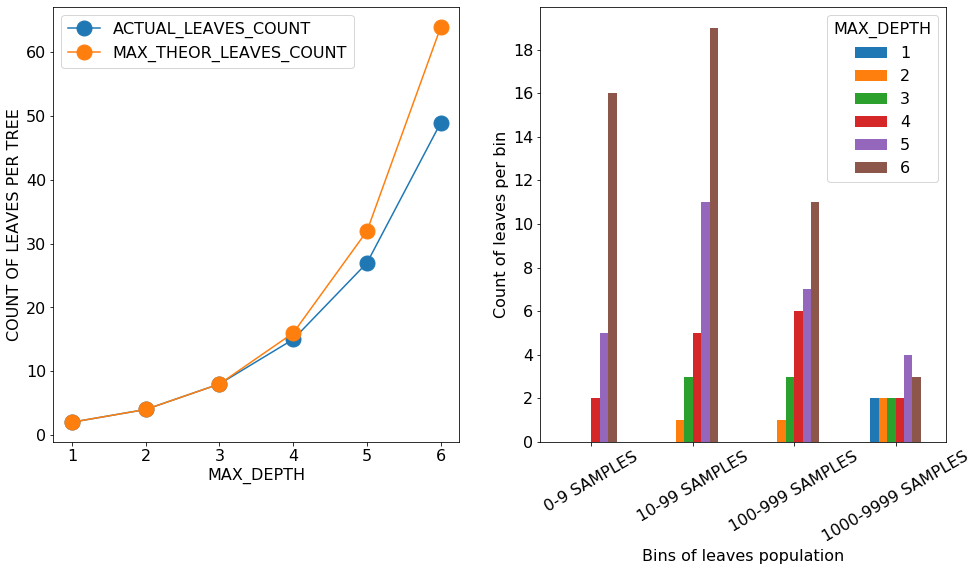

In [11]:
fig_1 = plt.figure(figsize=(16,8))

fig_1_a = plt.subplot(121)
ax1 = leaves_per_tree.plot(ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("COUNT OF LEAVES PER TREE")

fig_1_b = plt.subplot(122)
ax2 = leaves_per_bin.plot.bar(rot=30, ax = fig_1_b)
ax2.set_xlabel("Bins of leaves population")
ax2.set_ylabel("Count of leaves per bin")
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

### In this notebook, we highlight that increasing the max_depth alone will result in most leaf nodes having very small sample size (0-100) which makes generalizing and extracting statistically important results problematic

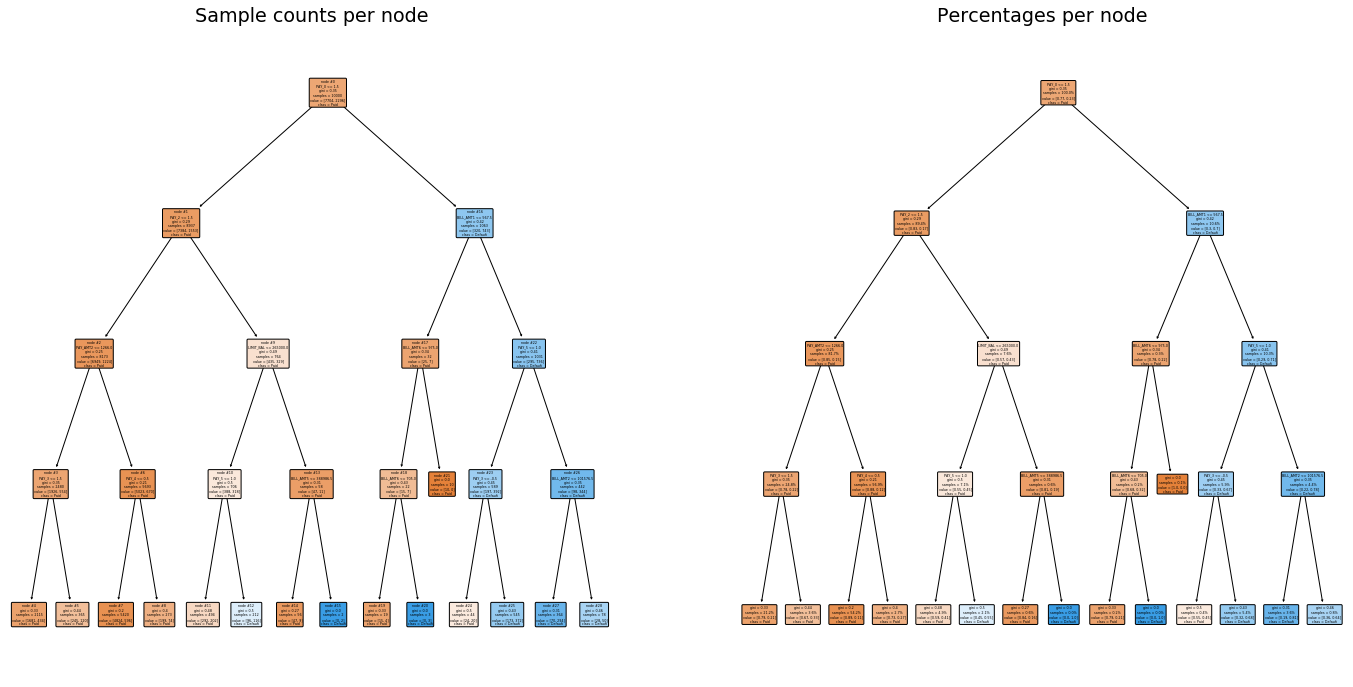

In [12]:
PLOT_TREE_NO = 3

fig_2 = plt.figure(figsize=(24,12))

fig_2_a = plt.subplot(121)
axs1 = plot_tree(estimator_max_depth[PLOT_TREE_NO], filled=True, feature_names = list(X.columns), class_names = ['Paid', 'Default'], rounded = True, precision = 2, node_ids=True)
fig_2_a.set_title('Sample counts per node')

fig_2_b = plt.subplot(122)
axs2 = plot_tree(estimator_max_depth[PLOT_TREE_NO], filled=True, feature_names = list(X.columns), class_names = ['Paid', 'Default'], rounded = True, precision = 2, proportion=True)
fig_2_b.set_title('Percentages per node')

plt.show()